In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import time
import pickle
import numpy as np

In [2]:
data_file = '../../data/Mumbai_House_Price.csv'
model_file = '../../models/RandomForest_1'

In [3]:
data = pd.read_csv(data_file)
for column in data:
    if column in ["bhk","status","type","age"]:
        print("Column Name: ", column)
        print(data[column].unique())
        print(data[column].value_counts())

Column Name:  bhk
[ 3  2  5  1  4  6  9  8 10  7]
bhk
2     31429
1     24613
3     15273
4      3934
5       606
6       148
7        16
8         8
10        6
9         5
Name: count, dtype: int64
Column Name:  type
['Apartment' 'Villa' 'Studio Apartment' 'Independent House' 'Penthouse']
type
Apartment            74854
Studio Apartment       882
Villa                  226
Independent House       73
Penthouse                3
Name: count, dtype: int64
Column Name:  status
['Ready to move' 'Under Construction']
status
Ready to move         44982
Under Construction    31056
Name: count, dtype: int64
Column Name:  age
['New' 'Resale' 'Unknown']
age
New        38072
Resale     23357
Unknown    14609
Name: count, dtype: int64


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def preprocessing(data: pd.DataFrame) -> pd.DataFrame:
    for index in data.index:
        price = data.loc[index, 'price']
        price_unit = data.loc[index, 'price_unit']
        # Process price
        if price_unit == 'Cr':
            data.loc[index, 'price_in_USD'] = (price * 10000000 * 0.012)
        elif price_unit == 'L':
            data.loc[index, 'price_in_USD'] = (price * 100000 * 0.012)
    data.drop(['price_unit',"price"], axis = 1, inplace = True)
    data = data.dropna()
    for column in data:
        if column in ["locality","region", "status", "age","type"]:
            data[column] = le.fit_transform(data[column])
    return data


In [5]:
processed_data = preprocessing(data)
for column in processed_data:
    print("Column Name: ", column)
    print(processed_data[column].unique())
    print(processed_data[column].value_counts())
processed_data.to_csv('../../data/processed_data_1.csv',index=False)

Column Name:  bhk
[ 3  2  5  1  4  6  9  8 10  7]
bhk
2     31429
1     24613
3     15273
4      3934
5       606
6       148
7        16
8         8
10        6
9         5
Name: count, dtype: int64
Column Name:  type
[0 4 3 1 2]
type
0    74854
3      882
4      226
1       73
2        3
Name: count, dtype: int64
Column Name:  locality
[3019 4965 7031 ...  319 1956 2301]
locality
2214    861
7921    516
9009    499
106     467
7122    389
       ... 
1991      1
6529      1
5348      1
6874      1
2301      1
Name: count, Length: 9782, dtype: int64
Column Name:  area
[ 685  640  610 ... 1974 1634 3049]
area
650     1662
1050    1381
1100    1151
1650    1041
750      950
        ... 
2369       1
1945       1
1442       1
2672       1
3049       1
Name: count, Length: 2331, dtype: int64
Column Name:  region
[  8 124  31 140 117 141  28 154  15  51  16  93  34  68 205  72 147  55
 194 213  26   2   5  30 217  91 198  78  67 120 136  62 190 151  56 197
  47  86 125  61  79  96   7  41 

In [6]:
X = processed_data.drop(labels="price_in_USD",axis=1)
Y = processed_data["price_in_USD"]
print(X.shape)
print(Y.shape)

(76038, 7)
(76038,)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [8]:
# from sklearn.model_selection import validation_curve
# 
# parameter_range = np.arange(1, 25, 1)
# 
# # Calculate accuracy on training and test set using the
# # gamma parameter with 4-fold cross validation
# train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=10, random_state=42), X_hold, Y_hold,
#                                           param_name="max_depth",
#                                           param_range=parameter_range,
#                                           cv=4, scoring="r2")
# 
# mean_train_score = np.mean(train_score, axis=1)
# std_train_score = np.std(train_score, axis=1)
# 
# mean_val_score = np.mean(val_score, axis=1)
# std_val_score = np.std(val_score, axis=1)
# 
# plt.plot(parameter_range, mean_train_score,
#          label="Training Score", color='b')
# plt.plot(parameter_range, mean_val_score,
#          label="Cross Validation Score", color='g')
# # Creating the plot
# plt.title("Validation Curve with Random Forest Regressor")
# plt.xlabel("Max depth")
# plt.ylabel("R2 Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [9]:
# from sklearn.model_selection import validation_curve
# 
# parameter_range = ["squared_error","absolute_error","friedman_mse", "poisson"]
# 
# # Calculate accuracy on training and test set using the
# # gamma parameter with 4-fold cross validation
# train_score, val_score = validation_curve(RandomForestRegressor(n_estimators=10, max_depth=20, random_state=42), X_hold, Y_hold,
#                                           param_name="criterion",
#                                           param_range=parameter_range,
#                                           cv=4, scoring="r2")
# mean_train_score = np.mean(train_score, axis=1)
# std_train_score = np.std(train_score, axis=1)
# 
# mean_val_score = np.mean(val_score, axis=1)
# std_val_score = np.std(val_score, axis=1)
# 
# plt.plot(parameter_range, mean_train_score,
#          label="Training Score", color='b')
# plt.plot(parameter_range, mean_val_score,
#          label="Cross Validation Score", color='g')
# # Creating the plot
# plt.title("Validation Curve with Random Forest Regressor")
# plt.xlabel("Criterion")
# plt.ylabel("R2 Score")
# plt.tight_layout()
# plt.legend(loc='best')
# plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(15, 30, 1),'max_features': [None, 'sqrt','log2']}
def hypersearch(model, model_name, param_grid, X_train, Y_train, scoring='r2'):
    # Hyperparameter tuning
    rs = GridSearchCV(model, param_grid,n_jobs=-1, cv=4, scoring=scoring, return_train_score=True)
    rs.fit(X_train, Y_train)
    best_model = rs.best_estimator_

    #add the report about best hyperparameter of the model to dataframe
    result = pd.DataFrame(rs.cv_results_)
    result.sort_values('rank_test_score', inplace=True)
    result = result[['params', 'mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score']]
    display(result)
    
    pickle.dump(best_model, open(model_name, 'wb'))
    return best_model

model = hypersearch(RandomForestRegressor(random_state=42), model_file, param_grid, X_train, Y_train)

,params,mean_fit_time,mean_score_time,mean_test_score,mean_train_score
39,"{'max_depth': 28, 'max_features': None}",18.667167,0.482406,0.874802,0.978818
36,"{'max_depth': 27, 'max_features': None}",18.995992,0.486536,0.874794,0.978681
42,"{'max_depth': 29, 'max_features': None}",18.991425,0.371165,0.874687,0.978779
30,"{'max_depth': 25, 'max_features': None}",18.639302,0.456839,0.874643,0.978446
24,"{'max_depth': 23, 'max_features': None}",17.643871,0.407389,0.874396,0.977894
27,"{'max_depth': 24, 'max_features': None}",18.048634,0.435724,0.874176,0.978146
33,"{'max_depth': 26, 'max_features': None}",18.150774,0.454449,0.873947,0.978524
21,"{'max_depth': 22, 'max_features': None}",17.199703,0.399869,0.873466,0.977364
18,"{'max_depth': 21, 'max_features': None}",17.138337,0.373148,0.873334,0.976729
15,"{'max_depth': 20, 'max_features': None}",16.102089,0.339804,0.872743,0.975835


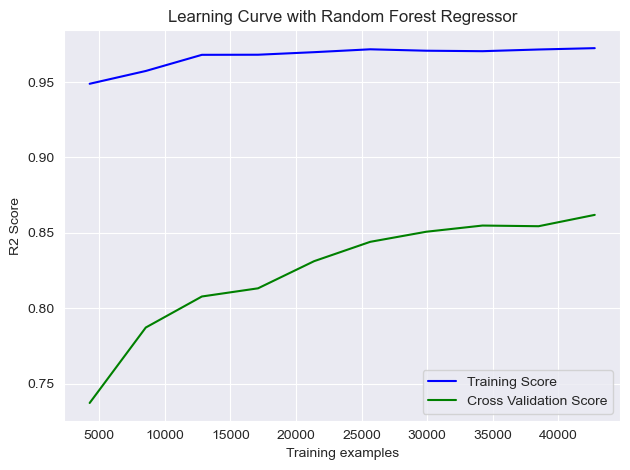

In [20]:
from sklearn.model_selection import learning_curve

# Calculate accuracy on training and test set using the
# gamma parameter with 4-fold cross validation
train_sizes, train_score, val_score = learning_curve(RandomForestRegressor(n_estimators=10,max_depth=28, max_features=None ,random_state=42), X_train, Y_train,
                                          cv=4, train_sizes=np.linspace(0.1, 1.0, 10),scoring="r2")

train_score_mean = np.mean(train_score, axis=1)
train_score_std = np.std(train_score, axis=1)

val_score_mean = np.mean(val_score, axis=1)
val_score_std = np.std(val_score, axis=1)

plt.plot(train_sizes, train_score_mean,
         label="Training Score", color='b')
plt.plot(train_sizes, val_score_mean,
         label="Cross Validation Score", color='g')
# Creating the plot
plt.title("Learning Curve with Random Forest Regressor")
plt.xlabel("Training examples")
plt.ylabel("R2 Score")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [12]:
# start = time.time()
# # Create the model
# model = RandomForestRegressor(n_estimators=10, random_state=42)
# print("Start training...")
# model.fit(X_train, Y_train)
# end = time.time()
# print("Time execution : ", end - start)
# pickle.dump(model, open(model_file, 'wb'))

In [13]:
loaded_model = pickle.load(open(model_file, 'rb'))

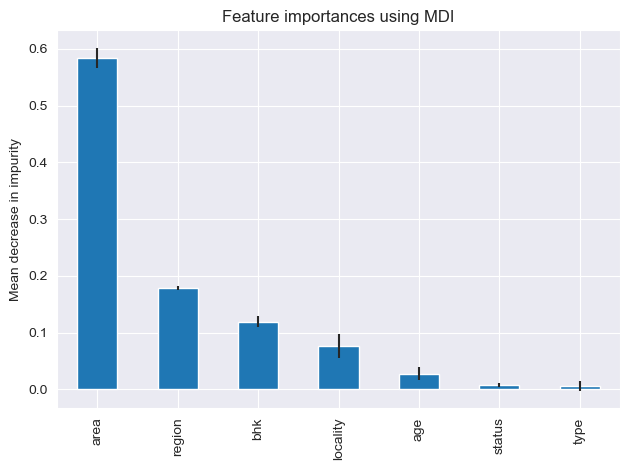

In [14]:
feature_names = [f"{column}" for column in X_train]
importances = loaded_model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in loaded_model.estimators_], axis=0)
sorted_importances = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots()
sorted_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [15]:
#Make the predictions 
Y_pred = loaded_model.predict(X_test)
pred_table = pd.DataFrame(data={"actual value":Y_test, "predicted":Y_pred})
pred_table["difference"] = pred_table["actual value"] - pred_table["predicted"]
pred_table

,actual value,predicted,difference
30699,99600.0,98761.864494,838.135506
36534,186000.0,212180.788752,-26180.788752
23586,39000.0,41708.400000,-2708.400000
11125,116400.0,133503.240000,-17103.240000
54910,432000.0,555792.000000,-123792.000000
...,...,...,...
64796,252000.0,232685.600515,19314.399485
65343,390000.0,390000.000000,0.000000
4066,360000.0,319207.127706,40792.872294
25584,243600.0,263628.000000,-20028.000000


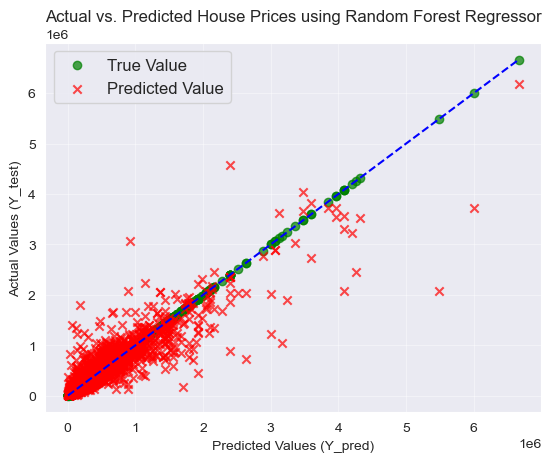

In [16]:
# Assuming you have obtained Y_pred and Y_test from your model

# Create a scatter plot or line plot
# Scatter plot for Y_test (green)
plt.scatter(Y_test, Y_test, c='green', marker='o', label='True Value', alpha=0.7)

# Scatter plot for Y_pred (red)
plt.scatter(Y_test, Y_pred, c='red', marker='x', label='Predicted Value', alpha=0.7)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'b--')  # Diagonal line for reference
plt.xlabel('Predicted Values (Y_pred)')
plt.ylabel('Actual Values (Y_test)')
plt.legend(fontsize=12)
plt.title('Actual vs. Predicted House Prices using Random Forest Regressor')
plt.grid(alpha=0.4)
# Show the plot
plt.show()

In [17]:
from sklearn.metrics import r2_score
#Test the model
pred_train = loaded_model.predict(X_train)
pred_test = loaded_model.predict(X_test)
train_accuracy = r2_score(pred_train, Y_train)
test_accuracy = r2_score(pred_test, Y_test)
print('Training r2 score: ',train_accuracy)
print('Test r2 score: ',test_accuracy)

Training r2 score:  0.9785490866402652
Test r2 score:  0.861153762969939


In [18]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(Y_train, pred_train)
mse_test = mean_squared_error(Y_test, pred_test)
print('Training mean squared error: ', mse_train)
print('Test mean squared error: ', mse_test)

Training mean squared error:  1380012363.5802684
Test mean squared error:  8052043799.270716


In [19]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(Y_train, pred_train)
mae_test = mean_absolute_error(Y_test, pred_test)
print('Training mean absolute error: ', mae_train)
print('Test mean absolute error: ', mae_test)

Training mean absolute error:  11168.440069271468
Test mean absolute error:  25918.89732914448
